In [2]:
"""
referensi

https://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-i-8e702ca6675b
https://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-ii-47f3a13601a2
https://www.kaggle.com/kerneler/starter-clash-royale-top-battles-91c02b8d-6
https://www.kaggle.com/freakyoiseau/analyzing-card-performance-with-regression
"""

'\nreferensi\n\nhttps://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-i-8e702ca6675b\nhttps://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-ii-47f3a13601a2\nhttps://www.kaggle.com/kerneler/starter-clash-royale-top-battles-91c02b8d-6\nhttps://www.kaggle.com/freakyoiseau/analyzing-card-performance-with-regression\n'

# Bagian 1: Clustering

In [3]:
# Import library yang dibutuhkan
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates

In [4]:
!pip install kmodes

In [40]:
df = pd.read_csv("kartu.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127808 entries, 0 to 127807
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  127808 non-null  int64 
 1   0           127808 non-null  object
 2   1           127808 non-null  object
 3   2           127808 non-null  object
 4   3           127808 non-null  object
 5   4           127808 non-null  object
 6   5           127808 non-null  object
 7   6           127808 non-null  object
 8   7           127808 non-null  object
dtypes: int64(1), object(8)
memory usage: 8.8+ MB


In [5]:
# datasaet kartu
df = pd.read_csv("kartu.csv")
df = df.head(80) # tes sebagian
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7
0,0,ElixirGolem,HealSpirit,eDragon,Exe,NightWitch,Rage,BattleHealer,Tornado
1,1,Sparky,RamRider,eBarbs,Musk,Prince,Tesla,Arrows,Fireball
2,2,DarkPrince,IceWiz,GoblinCage,InfernoD,Tornado,Lightning,ElectroGiant,Bomber
3,3,Witch,DarkPrince,Poison,Log,RoyalRecruits,Prince,FlyingMachine,Snowball
4,4,Bandit,Horde,Sparky,Archers,Skellies,Zap,Princess,Giant


In [6]:
# Cek missing value
def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df)
    
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])

cek_null(df)


Empty DataFrame
Columns: [Total, Percent]
Index: []


In [7]:
# Cek missing value per atribut
df.isna().sum()

Unnamed: 0    0
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
dtype: int64

In [8]:
# Cek jumlah duplikasi data
df.duplicated().sum()

0

In [9]:
# Cek jumlah outliers per atribut
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1

whisker_min = Q1 - 1.5 * IQR
whisker_max = Q3 + 1.5 * IQR

((df < whisker_min) | (df > whisker_max)).sum()

<ipython-input-9-b614e6b49e0a>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < whisker_min) | (df > whisker_max)).sum()
<ipython-input-9-b614e6b49e0a>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < whisker_min) | (df > whisker_max)).sum()


0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
Unnamed: 0    0
dtype: int64

In [10]:
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80 non-null     int64 
 1   0           80 non-null     object
 2   1           80 non-null     object
 3   2           80 non-null     object
 4   3           80 non-null     object
 5   4           80 non-null     object
 6   5           80 non-null     object
 7   6           80 non-null     object
 8   7           80 non-null     object
dtypes: int64(1), object(8)
memory usage: 5.8+ KB


In [12]:
df.describe()

,Unnamed: 0
count,80.0000
mean,39.5000
std,23.2379
min,0.0000
25%,19.7500
50%,39.5000
75%,59.2500
max,79.0000


In [13]:
# Diadaptasi dari 
# https://docs.google.com/spreadsheets/d/1wIH69gfuCCoPRoWOIyUqQHMKkUfpb4GAxUbBYX8PwRc/edit#gid=1477229539
C = pd.read_csv('CRL_Cards_Classification2.csv')
cards_classifier = C.copy()
cards_classifier.pop('Type_1')
cards_classifier = cards_classifier.values.transpose()
cards_classifier

array([['Arrows', 'Minions', 'Archers', 'Knight', 'Fireball', 'MP',
        'Musk', 'Giant', 'WallBreakers', 'Prince', 'BabyD', 'Skarmy',
        'SpearGobs', 'Gobs', 'GobHut', 'Hog', 'Barrel', 'Hunter',
        'Bomber', 'Skellies', 'Tombstone', 'Valk', 'GiantSkelly',
        'Witch', 'Cannon', 'Barbs', 'BarbHut', 'Ram', 'BarbBarrel',
        'Golem', 'Zap', 'Horde', 'Inferno', 'MM', 'Lightning', 'PEKKA',
        'Miner', 'Lava', 'Bats', 'FireSpirit', 'Furnace', 'Wiz',
        'Tornado', 'Poison', 'MagicArcher', 'NightWitch', 'Mortar',
        'SkellyBarrel', 'Rocket', 'FlyingMachine', 'XBow', 'Balloon',
        'Log', 'InfernoD', 'RoyalRecruits', 'RG', 'RoyalHogs', '3M',
        'DarkPrince', 'Guards', 'MegaKnight', 'Princess', 'Snowball',
        'IceSpirit', 'Pump', 'IceGolem', 'Freeze', 'Bowler', 'Lumber',
        'IceWiz', 'Rascals', 'GobGang', 'Earthquake', 'DartGob',
        'GobGiant', 'Bandit', 'Firecracker', 'eBarbs', 'HealSpirit',
        'BombTower', 'Rage', 'CannonCart', 

In [14]:
# Digunakan apabila ingin sorting terlebih dahulu berdasarkan tipenya
def order_row(list1):
  # Mapping input list made of cards with their type
  card_dictionary = dict(zip(cards_classifier[0], cards_classifier[1]))
  card_dictionary

  list_tot_classification = list()
  for m in list1:
    a = card_dictionary.get(m)
    list_tot_classification.append(a)

  list_tot_classification
  #['Spell', 'Troop', 'Troop', 'Win Condition', 'Spell', 'Troop', 'Troop', 'Troop']

  # Personalized Sorting
  class_dict = {'Win Condition': 0, 'Troop': 1, 'Building': 2, 'Spell': 3}

  ## sorted by win condition, Troop, Building then Spell
  list_tot_num = list()
  for m in list_tot_classification:
    a = class_dict.get(m)
    list_tot_num.append(a)
  
  print(list_tot_num, list1)
  ordered_list = [x for _,x in sorted(zip(list_tot_num, list1))]
  return ordered_list

#example
#list1 = ['Arrows',	'Baby Dragon',	'Bomber', 'Golem',	'Lightning',	'Mega Minion',	'Mini P.E.K.K.A',	'Night Witch', 'Cannon']
#ordered_list = order_row(list1)
#ordered_list

## Labeling the Entire Dataset

In [15]:
#flat everything in one list
one_row = list()

for k in df.drop(columns="Unnamed: 0", axis=1).values:
    for n in k:
        one_row.append(n)

one_row = pd.DataFrame(one_row)
one_row

,0
0,ElixirGolem
1,HealSpirit
2,eDragon
3,Exe
4,NightWitch
...,...
635,RamRider
636,Log
637,Princess
638,InfernoD


In [16]:
one_row[0].value_counts()

Zap            30
Valk           26
MegaKnight     22
Log            22
Fireball       19
               ..
BombTower       1
Tombstone       1
HealSpirit      1
Ram             1
ElixirGolem     1
Name: 0, Length: 96, dtype: int64

<AxesSubplot:title={'center':'Kartu paling banyak digunakan'}, ylabel='Nama kartu'>

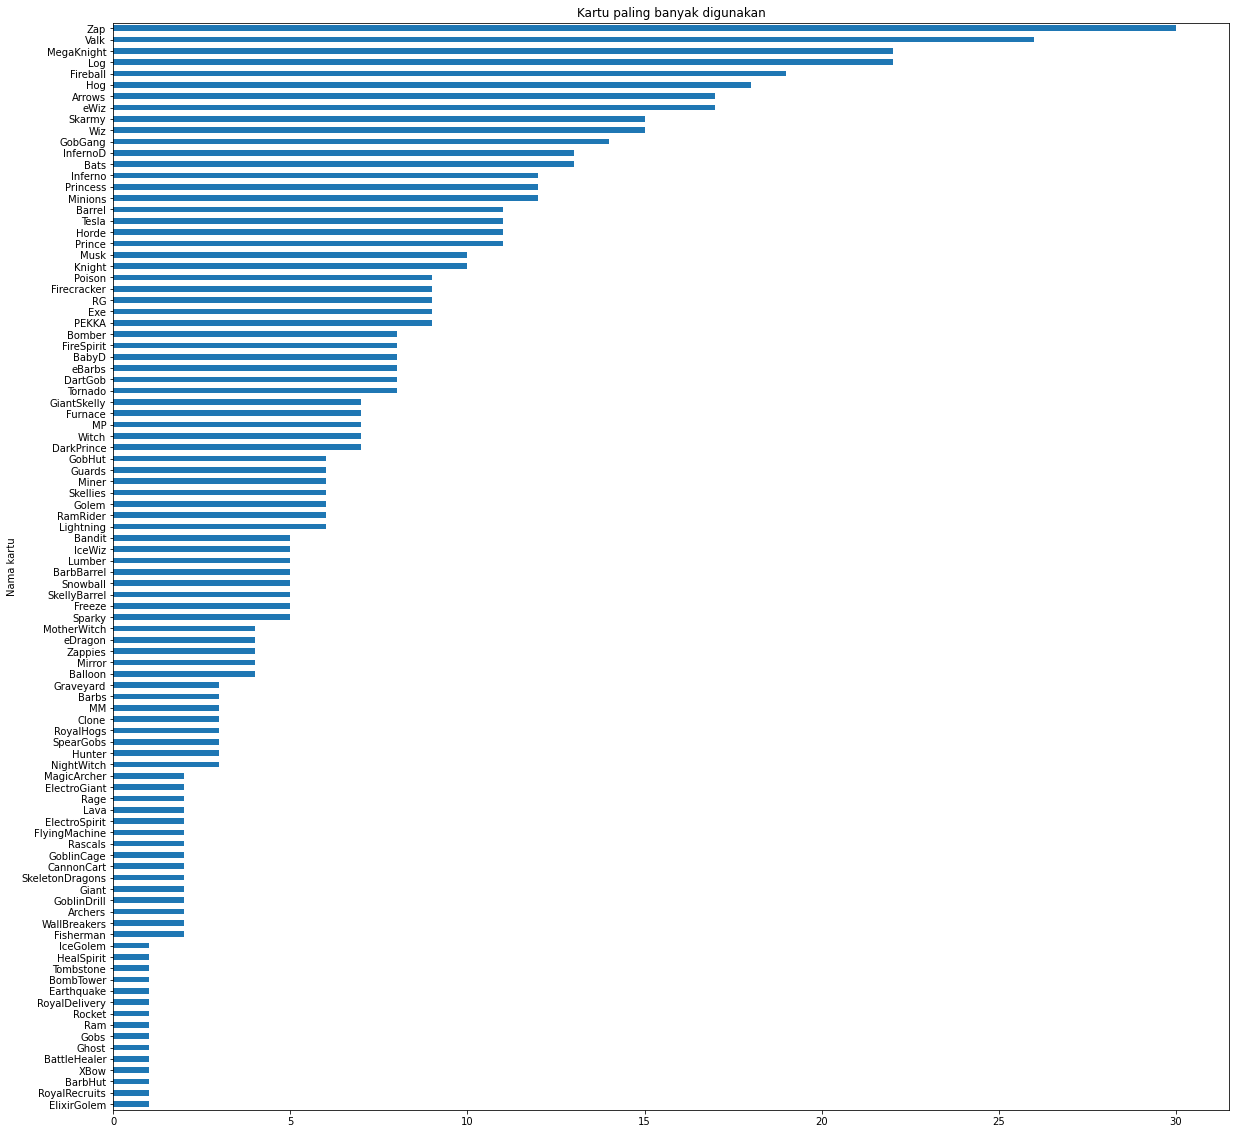

In [17]:
one_row[0].value_counts().sort_values(ascending=True).plot(kind='barh', title='Kartu paling banyak digunakan',
        xlabel='Nama kartu', figsize=(20, 20))

In [18]:
#labeled list
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(one_row[0])
one_row_labeled = le.transform(one_row[0])
one_row_labeled


array([20, 40, 94, 21, 62, 68, 10, 85, 81, 70, 93, 61, 65, 83,  1, 23, 15,
       45, 34, 47, 85, 50, 18, 12, 88, 15, 64, 51, 75, 65, 26, 80,  4, 42,
       81,  0, 78, 91, 66, 30, 58, 22, 86, 41, 91, 76, 46, 23, 41, 22, 86,
       51, 54, 39, 46, 23, 52,  3, 95, 56, 51, 65, 47,  8, 58, 32, 37, 57,
       91, 66, 76, 89, 56, 94, 70, 24, 86, 76,  1, 46, 95, 56, 45, 86, 66,
       59, 23,  8, 33, 56, 64, 61, 25, 92, 38, 80, 88, 32, 16, 86, 54, 89,
       46,  8, 33, 32, 86, 91, 83, 63, 89, 23, 95, 37, 62,  2, 91, 54, 76,
        1,  3, 53, 22, 86, 78, 89,  9, 27, 17, 31, 60, 25, 67, 92,  9, 12,
       48, 82, 79, 22, 86, 91,  9, 46, 52, 42, 14, 66, 76, 65,  1, 59, 52,
       56, 43, 24, 41, 86, 91, 55, 56, 41, 51, 39, 47,  1, 46, 23, 89, 28,
       33, 95, 41, 86, 63,  1, 58,  7, 28, 61, 86, 67, 50,  1, 95, 31, 45,
       24, 57, 86, 54,  5, 32, 95, 15, 91, 83, 93,  9, 23, 53, 51,  2, 67,
       78, 85,  9, 23,  4, 42, 89,  3, 81, 57, 76,  1, 58, 82, 56, 70, 51,
        2, 91, 66, 88, 32

In [19]:
#rebuild the original dataset and convert it to DataFrame
X_labeled = np.array_split(one_row_labeled, (len(one_row)/8))
X_labeled = pd.DataFrame(X_labeled)
X_labeled

,0,1,2,3,4,5,6,7
0,20,40,94,21,62,68,10,85
1,81,70,93,61,65,83,1,23
2,15,45,34,47,85,50,18,12
3,88,15,64,51,75,65,26,80
4,4,42,81,0,78,91,66,30
...,...,...,...,...,...,...,...,...
75,58,4,16,87,91,66,93,8
76,38,95,56,60,51,66,63,89
77,48,21,41,63,47,1,23,12
78,32,72,41,86,51,91,66,46


In [20]:
print(max(one_row_labeled+1), len(X_labeled))

96 80


Our dataset has a total of 103 cards used among players in any possible deck. This means that for every row there have to be 103 columns, each one representing a dummy variable.

In [21]:
m = np.zeros(shape=(len(X_labeled), max(one_row_labeled)+1))

print(m.shape)

for row in range(len(X_labeled)):
  for col in X_labeled.columns:
    m[row][X_labeled.loc[row, col]] = 1

m = pd.DataFrame(m)
m

(80, 96)


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
77,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Pada Clustering kali ini akan digunakan K-Mode. 

#### Alasan Penggunaan K-Mode

Sebelumnya, terdapat beberapa variasi algoritma clustering, dan yang dipelajari pada mata kuliah KASDD ini adalah Hierarchical clustering dan K-Means. K-Means memiliki kompleksitas waktu linier atau O(n) sedangkan Hierarchical clustering memiliki kompleksitas waktu kuadratik O(n^2) sehingga Hierarchical clustering kurang dapat meng-handle data yang cukup besar dengan baik. K-Mode merupakan adaptasi algoritma K-Means yang ditujukan untuk data categorical sehingga pada kasus ini digunakan K-Mode.

## Clustering

### Cluster Analysis

Akan dilakukan identifikasi jumlah cluster yang paling optimal

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


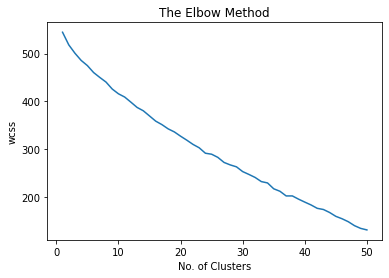

In [22]:
#graph the number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 51):
  km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 20, random_state = 0)
  km.fit(m)
  wcss.append(km.inertia_)

plt.plot(range(1, 51), wcss)
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

![](https://github.com/ichsanulamal/intro-to-AIDS/raw/master/elbow_method.png)

Identifikasi jumlah cluster yang paling optimal dilakukan dengan menggunakan elbow method. Biasanya, pada garis yang mulanya menurun sedikit demi sedikit terdapat titik yang kemudian mendatar sangat ekstrem. Titik itulah yang biasanya digunakan sebagai pemilihan jumlah cluster. Namun, pada grafik di atas kurang terlihat dengan jelas titik tersebut, sehingga dilakukan perkiraan di sekitar 20. Karena data yang kami gunakan bersifat categorical dan akan menggunakan K-Mode, sangat sulit untuk menentukan jumlah cluster terbaik, sehingga dipilih 20 dahulu untuk pemilihan sementara.

In [23]:
#mapping each row to its correponding cluster
from kmodes.kmodes import KModes
test=KModes(n_clusters=20, init='Cao')


cluster=test.fit_predict(m, categorical=list(m.columns))
cluster

array([ 2,  3,  5,  8,  6,  0,  0,  1, 10,  1, 11,  8,  7, 12, 10, 17,  5,
        0, 19,  0,  1, 12, 12, 11,  3,  3,  6, 13,  0,  5,  9,  0,  5,  7,
       11, 16, 10,  3,  1,  0,  4,  1,  1,  6, 14,  7, 11,  0,  0,  8,  1,
        0,  3, 18,  1,  3, 11,  9,  0,  3,  2,  0,  2,  1,  0,  0, 17,  6,
       15, 14, 14, 10, 19,  4,  4,  6,  4,  1,  0, 13], dtype=uint16)

In [24]:
test.cluster_centroids_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

20 list di atas merupakan one_hot numbers yang mendeskripsikan fitur untuk setiap single cluster. Setiap baris terdiri dari 103 elements, beberapa kolom bernilai 1, dan mayoritas bernilai 0. Untuk setiap single list, 103 binary values tersebut akan dikonversikan ke numbers, kemudian diubah menjadi nama card-nya untuk mendapatkan 20 meta-decks.

Akan dilakukan translasi dari output model K-Mode menjadi string original nya

In [38]:
#convert one_hot numbers to final decks

archetypes_list = list()

#for each 1 inside the one_hot cluster form return its number
#not all clusters have the same lenght
#store all number is arrays
cc = list()
for n_centroids in range(len(km.cluster_centroids_)):
  for k in range(len(km.cluster_centroids_[n_centroids])):
    if km.cluster_centroids_[n_centroids][k] == 1:
      cc.append(k)

#determines number of chunks per cluster
n_chunks = list()
for am in range(len(km.cluster_centroids_)):
  n_chunks.append((list(km.cluster_centroids_[am]).count(1)))
print(n_chunks)

#creates the meta-decks
from itertools import islice
it = iter(cc)
sliced =[list(islice(it, 0, i)) for i in n_chunks]
print(sliced)

sliced_list = list()
#convertion numbers to card names
for o in sliced:
  sliced_list.append(list(le.inverse_transform(o)))

#we only conserv the win conditions
card_dictionary = dict(zip(cards_classifier[0], cards_classifier[1]))
card_dictionary

#making a copy of the dataset, .copy() does not work
list_tot_classification = [x[:] for x in sliced_list] 

for o1 in range(len(list_tot_classification)):
  for o2 in range(len(list_tot_classification[o1])):
    a = card_dictionary.get(list_tot_classification[o1][o2])
    list_tot_classification[o1][o2] = a

only_win_conditions = list()
#only conserve lists with win conditions
for o3 in range(len(list_tot_classification)):
  if 'Win Condition' in list_tot_classification[o3]:
    only_win_conditions.append(sliced_list[o3])

print(only_win_conditions)
#store all the lists with a lenght of 8: full decks
for _ in sorted(only_win_conditions):
  if len(_) == 8:
    archetypes_list.append(_)
  
archetypes_list

[2, 3, 1, 3, 3, 2, 3, 6, 4, 3, 4, 3]
[[86, 91], [47, 51, 56], [21], [1, 61, 65], [51, 63, 95], [12, 42], [4, 42, 91], [8, 16, 32, 48, 79, 86], [56, 64, 65, 80], [14, 28, 79], [2, 37, 62, 76], [8, 56, 86]]
[['InfernoD', 'Log', 'MegaKnight'], ['Log', 'PEKKA', 'eWiz'], ['Barrel', 'DartGob', 'GobGang', 'Knight', 'SkellyBarrel', 'Valk'], ['MegaKnight', 'Poison', 'Prince', 'Snowball'], ['Clone', 'Furnace', 'SkellyBarrel'], ['BabyD', 'Golem', 'NightWitch', 'Skarmy'], ['Barrel', 'MegaKnight', 'Valk']]


[]

### Tuning Jumlah Cluster

In [26]:
import numpy as np
from kmodes.kmodes import KModes

archetypes_len = list()
for clus in range (8, 60): 
  km = KModes(n_clusters=clus, init='Cao', n_init=100, verbose=0)
  clusters = km.fit_predict(m)


  #one_hot results to archetypes sorted by win condition
  archetypes_list = archetypes(km.cluster_centroids_)
  archetypes_len.append(len(archetypes_list))
  for _ in archetypes_list:
    print(clus, _)
#25 is the optimal number of meta-decks

KeyboardInterrupt: 

In [ ]:
import seaborn as sns

archetypes_iteration = [x for x in range(8, 60)]
archetypes_iteration

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(archetypes_iteration, archetypes_len)

Dapat dilihat, semakin tinggi jumlah cluster, semakin banyak meta-decks yang serupa. 

### Kesimpulan Mengenai Jumlah Cluster:
- Jika jumlah cluster terlalu kecil, akan didapati meta-decks yang sedikit juga. Meta-decks tersebut mungkin memang merupakan yang terbaik, tetapi hanya merepresentasikan sedikit meta-decks saja, padahal terdapat meta-decks yang lainnya juga.
- Apabila jumlah cluster terlalu besar, yang didapatkan bukan hanya list dari top meta-decks saja, tetapi juga variasi dari card utama pada list meta-deck tersebut.

#### Estimasi top meta decks

Setelah dilakukan analisis lebih lanjut, jumlah cluster yang paling sesuai untuk menampilkan meta decks dengan variasi paling minimal adalah 25. Dapat disimpulkan bahwa berikut ini merupakan meta-decks pada saat dataset `kartu.csv` digunakan.

In [ ]:
# final cluster
n_clusters = 50
km = KModes(n_clusters=n_clusters, init='Cao', n_init=100, verbose=0)
clusters = km.fit_predict(m)

#one_hot results to archetypes sorted by win condition
archetypes_list = archetypes(km.cluster_centroids_)
for _ in archetypes_list:
  print(_)

m["target"] = clusters

Output apabila semua data digunakan
```
['Fireball' 'Horde' 'Skarmy' 'Wiz']
['Clone' 'GiantSkelly' 'SkellyBarrel']
['PEKKA' 'Tornado' 'eWiz']
['BabyD' 'MegaKnight' 'Witch']
['DarkPrince' 'Fireball' 'eWiz']
['Hog' 'Log' 'Tesla']
['Firecracker' 'Tesla' 'Zap']
['Balloon' 'InfernoD' 'Valk']
['BabyD' 'Tornado']
['Golem' 'NightWitch']
['Arrows' 'Valk']
['PEKKA' 'Zap']
['Skarmy' 'Zap']
['Bats' 'MegaKnight']
['Barrel' 'Valk']
['MM' 'Zap']
['Arrows' 'Fireball']
['Log' 'Skarmy']
['DarkPrince' 'Log']
['Zap' 'eBarbs']
['Arrows']
['Barrel']
['Poison']
['Bomber']
[]
```

# Bagian 2: prediksi

Salah satu permasalahan besar clash royale ada pada deck building. Banyak pemain tahu beberapa kartu yang ingin mereka pakai, tetapi tidak tahu kartu mana yang paling baik untuk melengkapi deck mereka. Pada bagian ini akan diberikan rekomendasi kartu yang perlu ditambahkan berdasarkan inputan dari pemain.

Berdasarkan clustering yang telah dilakukan di awal, telah didapatkan jumlah cluster yang cukup optimal, yaitu sebanyak 25 cluster. Untuk memberikan rekomendasi kartu pelengkap pada pemain berdasarkan kartu yang diinputnya, bisa digunakan berbagai model klasifikasi. Akan dicoba berbagai model tersebut untuk dilihat berbagai metricnya.

## Preprocessing

In [ ]:
from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    

def evaluate_classifier_performance(y_pred, y_test, classifier):
    # Informasi evaluasi secara compact
    
    print("Hasil Evaluasi:\n\n%s\n" % (classification_report(y_test, y_pred)))

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision Macro Average:', precision_score(y_test, y_pred, average='macro'))
    print('Precision Micro Average:', precision_score(y_test, y_pred, average='micro'))
    print('Recall Macro Average:', recall_score(y_test, y_pred, average='macro'))
    print('Recall Micro Average:', recall_score(y_test, y_pred, average='micro'))
    print('F1 Macro Average:', f1_score(y_test, y_pred, average='macro'))
    print('F1 Micro Average:', f1_score(y_test, y_pred, average='micro'))

    # Confusion Matrix
    print("\n\nConfusion Matrix\n")
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=classifier.classes_).plot()

In [ ]:
m = pd.read_csv("cluster_output.csv")


In [ ]:
m.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '94', '95', '96', '97', '98', '99', '100', '101', '102', 'target'],
      dtype='object', length=105)

In [ ]:
from sklearn.model_selection import train_test_split

X = m.drop(columns=["target", "Unnamed: 0"], axis=1)
y = m["target"]

# Membentuk 4 variabel X_train, X_test, y_train, dan y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=2021)

## Train Model 

#### KNeighborsClassifier
Berikut adalah hasil evaluasi klasifikasi dataset apabila menggunakan KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      8043
           1       0.77      0.77      0.77      4617
           2       0.72      0.63      0.67      1842
           3       0.75      0.86      0.80      1075
           4       0.82      0.70      0.76      2429
           5       0.77      0.53      0.63      1680
           6       0.80      0.91      0.85       913
           7       0.79      0.68      0.73       455
           8       0.73      0.95      0.83      4670
           9       0.79      0.89      0.83      2574
          10       0.73      0.89      0.80      2500
          11       0.76      0.87      0.81      2381
          12       0.77      0.75      0.76      1657
          13       0.78      0.65      0.71       867
          14       0.82      0.55      0.66      1037
          15       0.66      0.81      0.73      1562
          16       0.78      0.62      0.69      1119
          

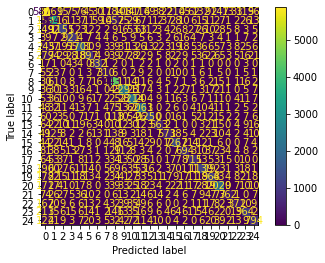

In [ ]:
# Memanggil fungsi evaluasi untuk MLP Classifier
evaluate_classifier_performance(knn_pred, y_test, knn)

#### Naive Bayes
Berikut adalah hasil evaluasi klasifikasi dataset apabila menggunakan Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_pred = bayes.predict(X_test)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      8043
           1       0.79      0.79      0.79      4617
           2       0.71      0.67      0.69      1842
           3       0.52      0.69      0.59      1075
           4       0.80      0.75      0.77      2429
           5       0.91      0.65      0.76      1680
           6       0.67      0.90      0.77       913
           7       0.66      0.85      0.74       455
           8       0.76      0.89      0.82      4670
           9       0.71      0.86      0.78      2574
          10       0.69      0.78      0.73      2500
          11       0.64      0.72      0.68      2381
          12       0.79      0.77      0.78      1657
          13       0.61      0.67      0.64       867
          14       0.87      0.53      0.66      1037
          15       0.49      0.77      0.60      1562
          16       0.71      0.57      0.63      1119
          

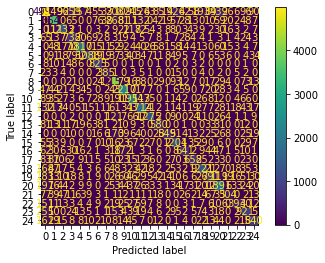

In [ ]:
# Memanggil fungsi evaluasi untuk MLP Classifier
evaluate_classifier_performance(bayes_pred, y_test, bayes)

#### Decision Tree (Gini & Entropy)
Berikut adalah hasil evaluasi klasifikasi dataset apabila menggunakan Decision Tree. Kali ini menggunakan variasi Gini & Entropy untuk Decision Tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

classifier_dt_gini = DecisionTreeClassifier(max_depth = 10, random_state = 2021, criterion='gini')
classifier_dt_gini.fit(X_train, y_train)
y_pred_dt_gini = classifier_dt_gini.predict(X_test)

classifier_dt_entropy = DecisionTreeClassifier(max_depth = 10, random_state = 2021, criterion='entropy')
classifier_dt_entropy.fit(X_train, y_train)
y_pred_dt_entropy = classifier_dt_entropy.predict(X_test)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.91      0.53      0.67     13865
           1       1.00      0.98      0.99      4718
           2       1.00      0.92      0.96      1996
           3       0.84      0.44      0.58      2054
           4       0.99      0.96      0.98      2499
           5       1.00      0.89      0.94      1880
           6       0.61      0.95      0.74       586
           7       0.03      0.54      0.05        24
           8       1.00      0.99      1.00      4699
           9       0.99      0.98      0.99      2604
          10       1.00      0.97      0.98      2576
          11       0.86      0.97      0.91      2111
          12       0.99      0.98      0.98      1685
          13       0.26      0.98      0.41       232
          14       1.00      0.98      0.99      1050
          15       0.65      0.67      0.66      1517
          16       0.75      0.95      0.84       878
          

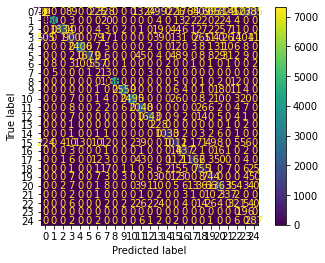

In [ ]:
# Evaluasi Varian Gini
evaluate_classifier_performance(y_test, y_pred_dt_gini, classifier_dt_gini)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.92      0.58      0.71     12620
           1       1.00      0.98      0.99      4715
           2       0.99      0.96      0.98      1913
           3       0.82      0.95      0.88       930
           4       0.96      0.96      0.96      2435
           5       1.00      0.91      0.95      1850
           6       0.61      0.96      0.75       581
           7       0.03      0.65      0.05        20
           8       1.00      0.99      1.00      4699
           9       1.00      1.00      1.00      2575
          10       1.00      0.98      0.99      2552
          11       0.89      0.96      0.93      2205
          12       0.99      0.99      0.99      1671
          13       0.99      0.94      0.96       910
          14       0.99      0.98      0.98      1039
          15       0.26      0.95      0.40       423
          16       0.38      0.49      0.43       863
          

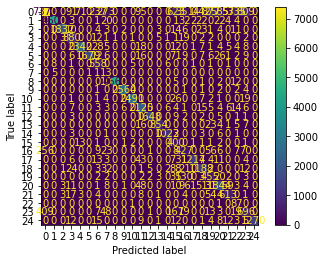

In [ ]:
# Evaluasi Varian Entropy
evaluate_classifier_performance(y_test, y_pred_dt_entropy, classifier_dt_entropy)

Dapat dilihat secara overall, model terbaik pada kasus percobaan ini adalah decision tree. Dengan demikian, rekomendasi mengenai kartu yang perlu ditambahkan agar menjadi meta-deck sudah dapat dibuat. Karena aplikasi ini memiliki tujuan untuk rekomendasi, alternatif lain yang bisa dilakukan adalah dapat diberikan beberapa prediksi sekaligus. Contohnya apabila menggunakan KNN, bisa ditambahkan sekitar 10 data terdekatnya dan diberikan rekomendasi pada pemain. Bisa juga apabila menggunakan Naive Bayes memilih beberapa cluster dengan peluang tertinggi untuk direkomendasikan pada pemain. Namun, pada kasus ini kami hanya merekomendasikan 1 deck saja yang paling meta pada pemain sesuai inputannya.

# Extras: Agar hasil prediksi bisa dibaca manusia

In [ ]:
def to_one_hot_encoding(a):
    a = le.transform(a)

    print(a)

    m = np.zeros(max(one_row_labeled)+1)
    
    for it in a:
        m[it] = 1

    return m

In [ ]:
def to_card(a):
    arr = []
    
    for it in range(len(a[0])):
        if a[0][it] == 1:
            arr.append(it)

    return le.inverse_transform(arr)
        

In [ ]:
# KNN
a = ['BattleHealer', 'ElixirGolem', 'Exe', 'HealSpirit', 'NightWitch', 'Rage', 'Tornado', 'eDragon']

c = knn.predict(np.reshape(to_one_hot_encoding(a), (1,-1)))

# Setelah didapatkan labelnya, bisa diberikan rekomendasi data yang sesuai dengan class
print(c)
print(m[m["target"] == c[0]])



[ 11  23  24  44  68  75  92 101]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


[0]
        Unnamed: 0    0    1    2    3    4  ...   98   99  100  101  102  target
0                0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0       0
4                4  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       0
17              17  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       0
23              23  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0       0
48              48  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       0
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...
127730      127730  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       0
127743      127743  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0       0
127753      127753  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  1.0  0.0       0
127775      127775  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0       0
127802      127802  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0       0

[20121 rows

In [ ]:
# Naive Bayes
a = ['Fireball', 'Inferno', 'Poison', 'Zap']

c = bayes.predict(np.reshape(to_one_hot_encoding(a), (1,-1)))

# Setelah didapatkan labelnya, bisa diberikan rekomendasi data yang sesuai dengan class
print(c)
print(m[m["target"] == c[0]])

[26 51 70 98]
[9]
        Unnamed: 0    0    1    2    3    4  ...   98   99  100  101  102  target
13              13  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       9
40              40  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0       9
61              61  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0       9
68              68  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       9
80              80  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  1.0  0.0  0.0       9
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...
127658      127658  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0       9
127681      127681  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0       9
127739      127739  0.0  0.0  0.0  0.0  1.0  ...  1.0  0.0  0.0  0.0  0.0       9
127769      127769  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       9
127797      127797  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0  0.0  1.0       

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
# Decision Tree
a = ['Fireball', 'Inferno', 'Poison', 'Zap']

c = classifier_dt_entropy.predict(np.reshape(to_one_hot_encoding(a), (1,-1)))

# Setelah didapatkan labelnya, bisa diberikan rekomendasi data yang sesuai dengan class
print(c)
print(m[m["target"] == c[0]])

[26 51 70 98]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


[4]
        Unnamed: 0    0    1    2    3    4  ...   98   99  100  101  102  target
11              11  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0       4
28              28  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       4
49              49  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0       4
74              74  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0       4
90              90  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0       4
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...
127747      127747  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0       4
127779      127779  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0       4
127781      127781  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0       4
127782      127782  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0       4
127805      127805  1.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  0.0  0.0       4

[6098 rows 

In [ ]:
#not used in the algorithm, but useful

#converter cards to labels
a = le.transform(['BattleHealer', 'ElixirGolem', 'Exe', 'HealSpirit', 'NightWitch', 'Rage', 'Tornado', 'eDragon'])
list(a)

#converter labels to cards
a = le.inverse_transform([2, 5, 40, 53, 64, 86])
list(a)

['Arrows', 'Bandit', 'Gobs', 'Knight', 'Mirror', 'SkellyBarrel']